# Term Paper

# Part 1

In [ ]:
import pandas as pd
import glob as glob
import matplotlib.pyplot as plt

In [8]:
#Defining a function to compute and print dataset statistics
def compute_statistics():
    num_individuals = sce_df["userid"].nunique() # Number of Unique userids (individuals)
    num_observations = len(sce_df)               # Total number of observations
    num_waves = sce_df["wid"].nunique()          # Number of Unique survey waves
    first_date = sce_df["date"].min()            # Earliest survey date
    last_date = sce_df["date"].max() # Latest survey date

    # Output the statistics
    print(f"Unique individuals: {num_individuals}") 
    print(f"Total observations: {num_observations}")
    print(f"Unique survey waves: {num_waves}")
    print(f"Date range: {first_date.date()} to {last_date.date()}")

In [9]:
files=glob.glob(f'data/SCE-*-20*.csv')

df_list=[]

waves_number=0

#Loop to read in and append files
for file in files:
    df=pd.read_csv(file,sep=";",parse_dates=['date'])
    df_list.append(df)


sce_df=pd.concat(df_list,ignore_index=True)

compute_statistics()

Unique individuals: 23369
Total observations: 176101
Unique survey waves: 139
Date range: 2013-06-01 to 2024-12-31


# Part 2

In [12]:
# Forward-fill numeracy variables for each individual
numeracy_cols = [
    'num_lit_q1_correct', 'num_lit_q2_correct', 'num_lit_q3_correct',
    'num_lit_q5_correct', 'num_lit_q6_correct', 'num_lit_q8_correct', 'num_lit_q9_correct'
]

# Replace blank strings with NaN (if your CSV uses empty fields)
sce_df[numeracy_cols] = sce_df[numeracy_cols].replace("", pd.NA)


# Group by userid, then forward-fill within each person
sce_df[numeracy_cols] = sce_df.groupby('userid')[numeracy_cols].ffill()

# Drop all rows that still have NaN
numeracy_cols.extend(['female','educ','age','inflation','house_price_change','prob_stocks_up'])
sce_df.dropna(subset=numeracy_cols,inplace=True)

#Eliminate 0.1th percentile and 99.9th percentile of answers
expectation_cols=[
    'inflation','house_price_change','prob_stocks_up'
]
lower_bounds=sce_df[expectation_cols].quantile(0.001)
upper_bounds=sce_df[expectation_cols].quantile(0.999)
for col in expectation_cols:
    sce_df=sce_df[(sce_df[col]>lower_bounds[col]) & (sce_df[col]< upper_bounds[col])]

#Creating a column to determine whether the individual has a bachelor's degree or higher
sce_df['college']=(sce_df['educ']>3).astype(int)

#Compute the total number of correct numeracy responces
numeracy_cols = [
    'num_lit_q1_correct', 'num_lit_q2_correct', 'num_lit_q3_correct',
    'num_lit_q5_correct', 'num_lit_q6_correct', 'num_lit_q8_correct', 'num_lit_q9_correct'
]
sce_df['numeracy_score']=sce_df[numeracy_cols].sum(axis=1)

#Compute the average numeracy score
percentage=sce_df['numeracy_score'].value_counts(normalize=True)*100
percentage.sort_index(inplace=True)
print(f"Numeracy Score Distribution (%): {percentage}")

#Creating a column to determine if the individual has a higher numeracy score than the median
median_score = sce_df['numeracy_score'].median()
sce_df['num_lit_high'] = (sce_df['numeracy_score'] > median_score).astype(int)

#Calling the function to compute and print updated dataset statistics
compute_statistics()

Numeracy Score Distribution (%): numeracy_score
0.0     0.128255
1.0     0.596781
2.0     1.905510
3.0     5.309514
4.0     9.295904
5.0    16.423243
6.0    27.624656
7.0    38.716137
Name: proportion, dtype: float64
Unique individuals: 17499
Total observations: 76410
Unique survey waves: 117
Date range: 2015-04-02 to 2024-12-31


# Part 3

# Expectations by Demographic Groups

The following graphs compare the average expectations for inflation, house price changes, and stock market performance based on different demographic groups.


## Gender

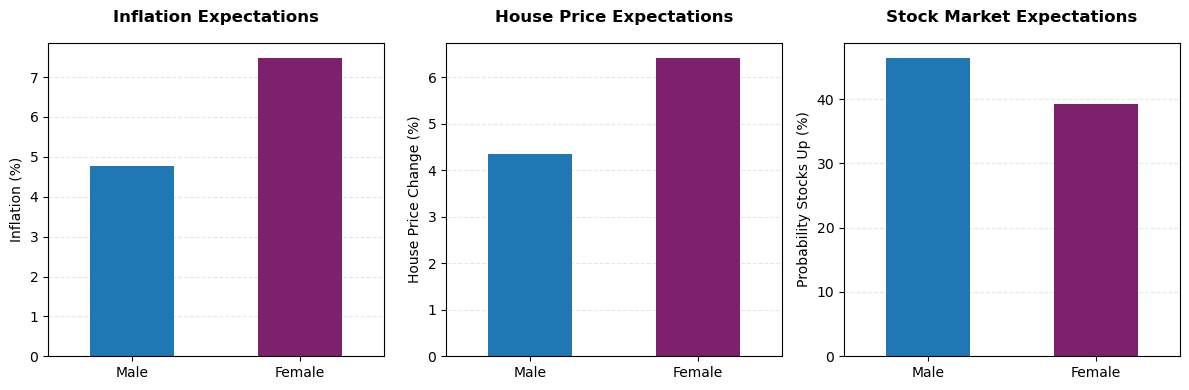

## Education

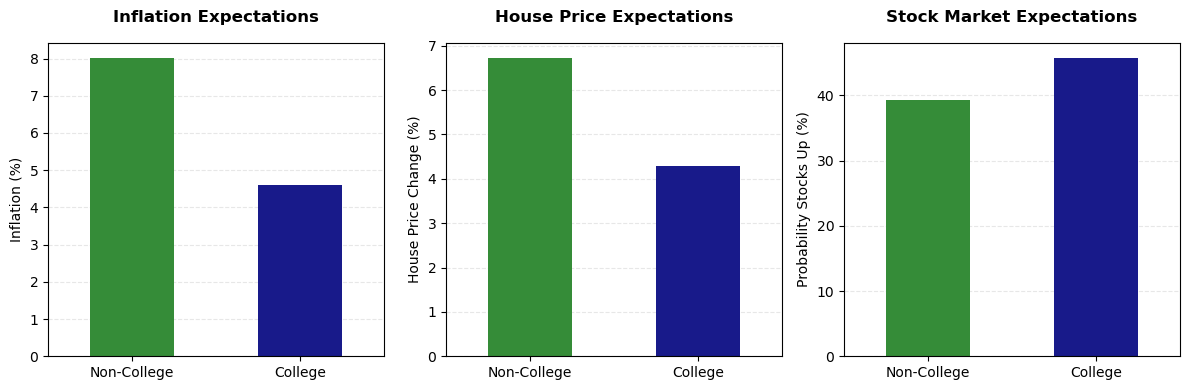

## Numeracy

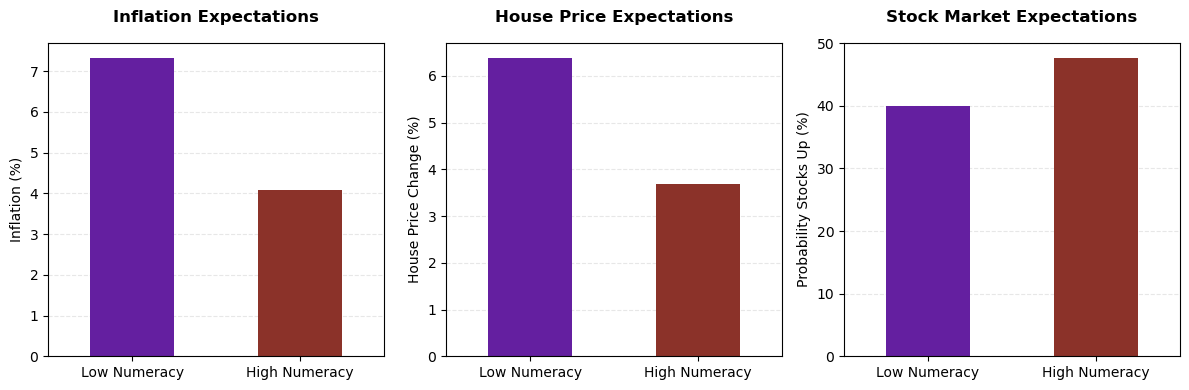

In [ ]:

#NOTE: Define constants outside the function, or earlier in document
#NOTE: remember to have uniform use of "" not '' in document

# Function to plot bar charts of expectations by group
def plot_expectation_bars_by_group(group_var, group_labels, Colors):
   
    # Calculate mean expectations by group_var (eg. female, college, num_lit_high)
    grouped = sce_df.groupby(group_var)[expectation_cols].mean()
    grouped.index = group_labels       #NOTE: ["inflation", etc list can be made into variable, and]           

    # Creates sublots for each expectation variable. 
    # Variables fig for the whole figure, axes for each subplot
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Create list of titles and y_labels to loop trough 
    titles = ["Inflation", "House Price", "Stock Market"] # NOTE: use variable list with some .upper() to get titles
    y_labels = ["Inflation (%)", "House Price Change (%)", "Probability Stocks Up (%)"]
    # loops trough i (index) and var (variables) in enumerate of variables list
    for i, var in enumerate(expectation_cols):
        # Plots bar chart 
        grouped[var].plot.bar(ax=axes[i], color=Colors, rot=0,) #rot=0 to keep x labels horizontal since df.plot.bar defaults to rot=45
                                          #NOTE can change color to function variable to change colors like ax
        # Sets title and y label for each subplot 
        axes[i].set_title(f"{titles[i]} Expectations", fontsize=12, fontweight="bold", pad=15) #maybe remove pad, adds space between title and plot
        axes[i].set_ylabel(y_labels[i]) #NOTE: maybe add fontsize

        # Adds grid lines for better readability, and set axis below so grid doesnt obsucre data
        axes[i].grid(axis="y", linestyle="--", alpha=0.3)
        axes[i].set_axisbelow(True)   

    plt.tight_layout()
    plt.show()

# Return functionsults in nicely formatted markdown headers

from IPython.display import display, Markdown # Import display to use markdown headers
# Main header and description
display(Markdown("# Expectations by Demographic Groups"))
print("The following graphs compare the average expectations for inflation, house price changes, and stock market performance based on different demographic groups.")

# Gender Comparison
display(Markdown("## Gender"))
plot_expectation_bars_by_group('female', ['Male', 'Female'], ['#1f77b4', "#7d216c"])

# Education Level Comparison
display(Markdown("## Education"))
plot_expectation_bars_by_group('college', ['Non-College', 'College'], ["#358c38", "#181a8a"])

# Numeracy Comparison
display(Markdown("## Numeracy"))
plot_expectation_bars_by_group('num_lit_high', ['Low Numeracy', 'High Numeracy'], ["#641fa0ff", "#8B3229"])
    

## Part 3 — Differences in Average Expectations

### 1. Gender Differences
Women have **higher average expectations** for both inflation and house-price growth compared to men,  
but are **less confident about the stock market**.  
This suggests that women tend to expect higher prices and more financial risk.

---

### 2. Education Differences
People with **a college degree** show **lower expectations** for inflation and house prices,  
but **higher confidence** in the stock market.  
This pattern points to more stable and informed expectations among higher-educated individuals.

---

### 3. Numeracy Differences
Those with **low numeracy** expect **higher inflation and house-price growth**,  
while those with **high numeracy** are **more optimistic about stock returns**.  
This indicates that people with stronger numerical skills may form more realistic and balanced economic views.

# Part 4

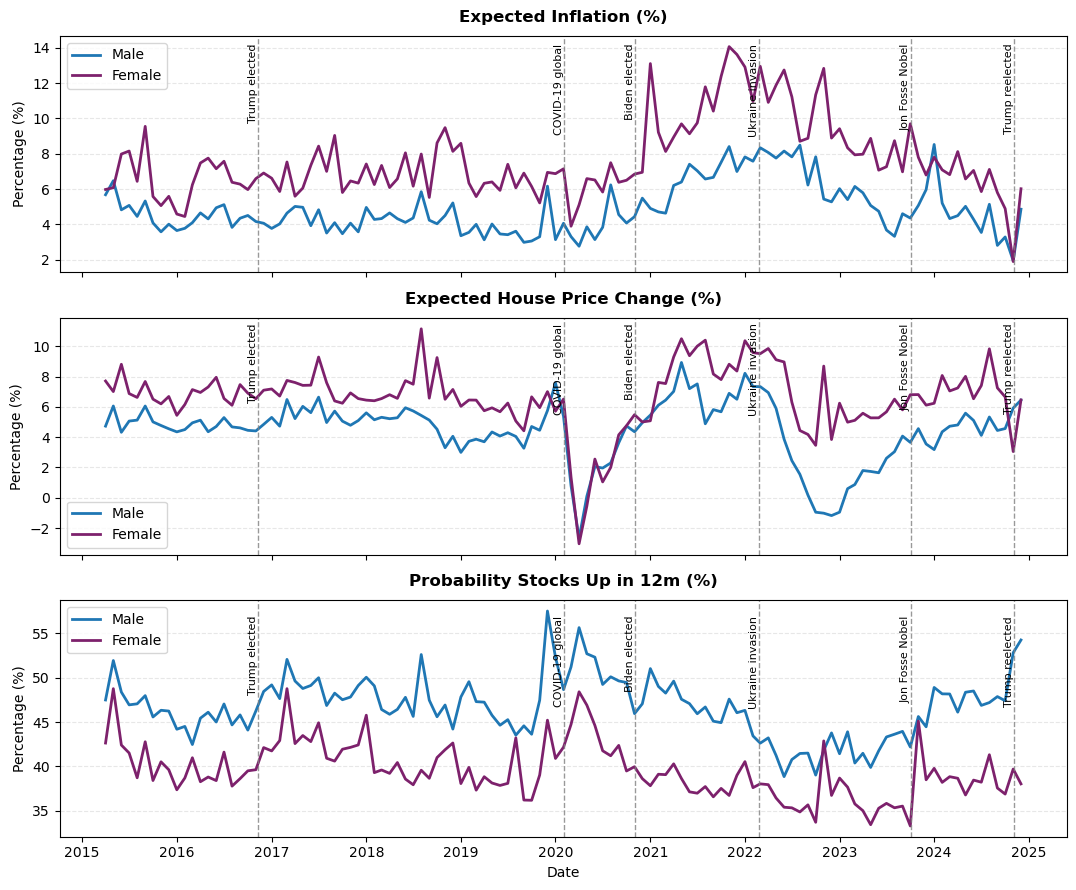

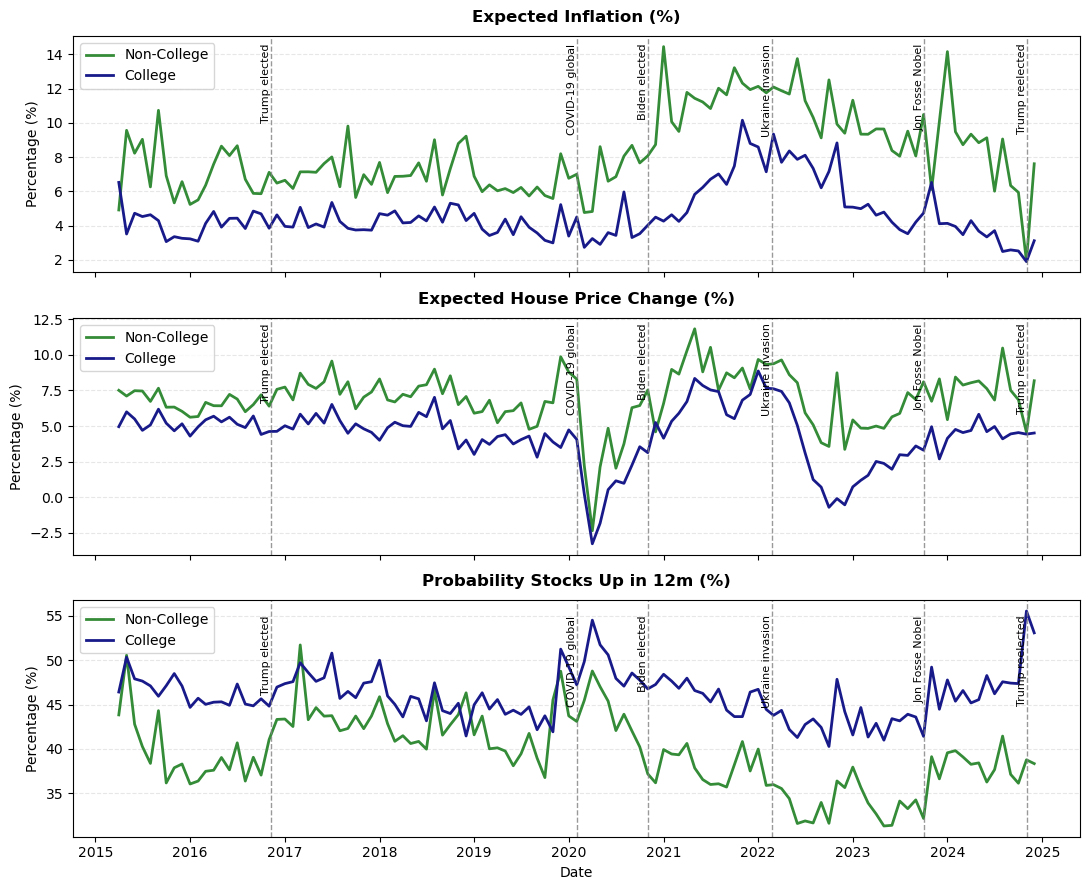

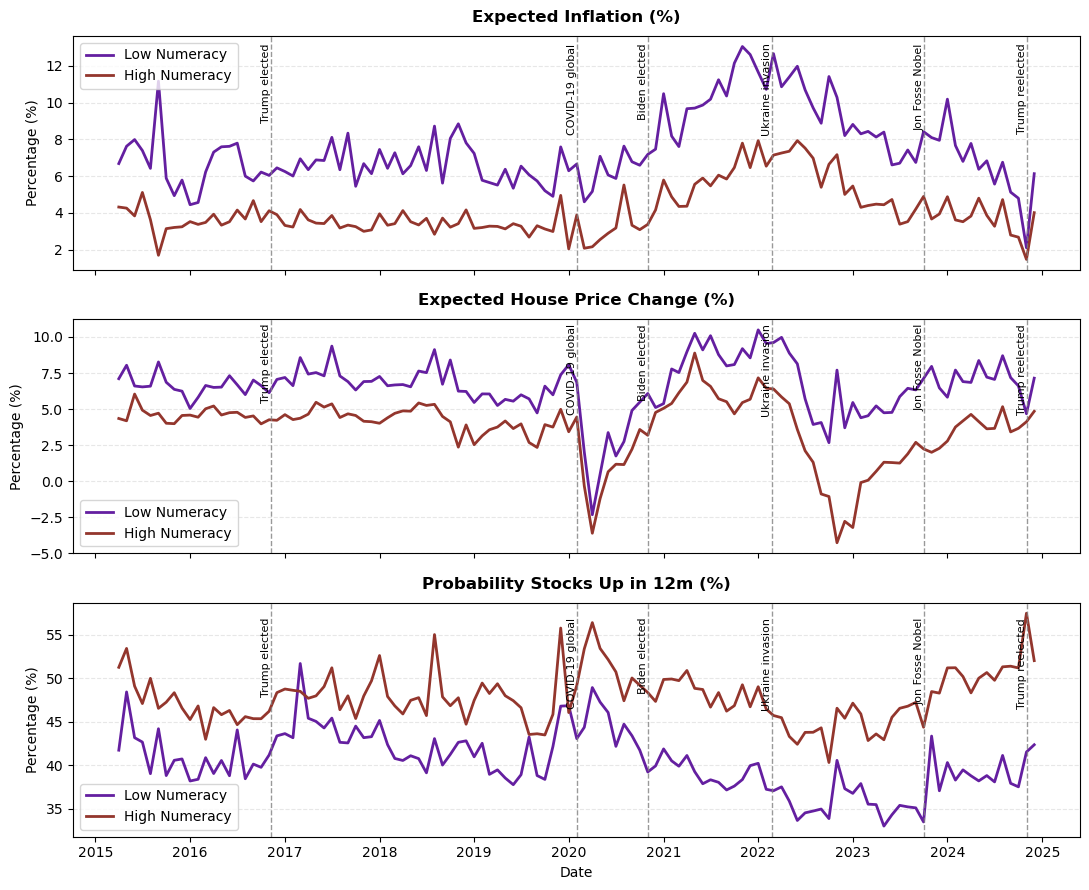

In [21]:
# Constants for plotting functions
expectation_cols = ["inflation", "house_price_change", "prob_stocks_up"]
titles = ["Expected Inflation (%)",
          "Expected House Price Change (%)",
          "Probability Stocks Up in 12m (%)"]


# Computing monthly group averages

def monthly_group_avg(df, group_var):
    """Calculate monthly mean expectations by group (e.g., female, college, num_lit_high)."""
    df_copy = df.copy()
    return (
        df_copy.groupby([group_var, pd.Grouper(key="date", freq="MS")])[expectation_cols]
        .mean()
        .reset_index()
        .sort_values(["date", group_var])
    )


# Function to plot expectation dynamics

def plot_expectation_dynamics(df_monthly, group_var, group_labels, colors):
    """Plot monthly average expectations with vertical event markers for key global events."""
    fig, axes = plt.subplots(3, 1, figsize=(11, 9), sharex=True)

    # Loop through the three expectation variables
    for i, var in enumerate(expectation_cols):
        ax = axes[i]
        for (val, label), color in zip(group_labels.items(), colors):
            subset = df_monthly[df_monthly[group_var] == val]
            ax.plot(subset["date"], subset[var], label=label, color=color, linewidth=2)
        ax.set_title(titles[i], fontsize=12, fontweight="bold", pad=10)
        ax.set_ylabel("Percentage (%)")
        ax.grid(axis="y", linestyle="--", alpha=0.3)
        ax.legend()

    # Key global events (same for all panels)
    events = [
        ("2016-11-08", "Trump elected"),
        ("2020-02-01", "COVID-19 global"),
        ("2020-11-03", "Biden elected"),
        ("2022-02-24", "Ukraine invasion"),
        ("2023-10-03", "Jon Fosse Nobel"),
        ("2024-11-05", "Trump reelected"),
    ]

    # Vertical dashed lines + labels
    for date_str, label in events:
        x = pd.to_datetime(date_str)
        for ax in axes:
            ax.axvline(x, color="gray", linestyle="--", linewidth=1, alpha=0.8)
            ymax = ax.get_ylim()[1]
            ax.text(x, ymax * 0.97, label, rotation=90, va="top", ha="right", fontsize=8)

    axes[-1].set_xlabel("Date")
    plt.tight_layout()
    plt.show()


# Calling functions (3 figures with matched color scheme)

# Gender Comparison
monthly_gender = monthly_group_avg(sce_df, "female")
plot_expectation_dynamics(monthly_gender, "female",
                          {0: "Male", 1: "Female"},
                          ["#1f77b4", "#7d216c"])  

# Education Comparison
monthly_college = monthly_group_avg(sce_df, "college")
plot_expectation_dynamics(monthly_college, "college",
                          {0: "Non-College", 1: "College"},
                          ["#358c38", "#181a8a"])

# Numeracy Comparison
monthly_numlit = monthly_group_avg(sce_df, "num_lit_high")
plot_expectation_dynamics(monthly_numlit, "num_lit_high",
                          {0: "Low Numeracy", 1: "High Numeracy"},
                          ["#641fa0ff", "#93362D"])

## Part 4 — Analysis of Expectations Over Time

### 1. Average Expectations

Overall, there are clear differences across gender, education, and numeracy:

- **Gender:** Women expect **higher inflation and house-price growth** than men, but are **less optimistic** about the stock market.  
- **Education:** People with **a college degree** have **lower and more stable expectations** for inflation and house prices.  
- **Numeracy:** Those with **low numeracy** expect **higher inflation and house-price growth**, but **lower stock-market returns**.

---

### 2. Reactions to Major Events

Expectations changed sharply during key events:

- The **COVID-19 pandemic (2020)** caused a **drop in house-price expectations** and a temporary spike in stock-market optimism.  
- The **Ukraine war (2022)** led to a strong **rise in inflation expectations** across all groups.  
- **Elections**, especially in **2016** and **2024**, created **short-term uncertainty** but smaller overall effects.

Less educated and less numerate groups tended to **react more strongly** and **recover more slowly** from shocks.

---

### 3. Relation to Actual Outcomes

Expectations move roughly in line with real economic outcomes, but many individuals seem to **extrapolate from recent events** rather than base their views on long-term trends.  
More educated and numerate people appear to form **steadier, better-informed expectations**.


### Part 5 

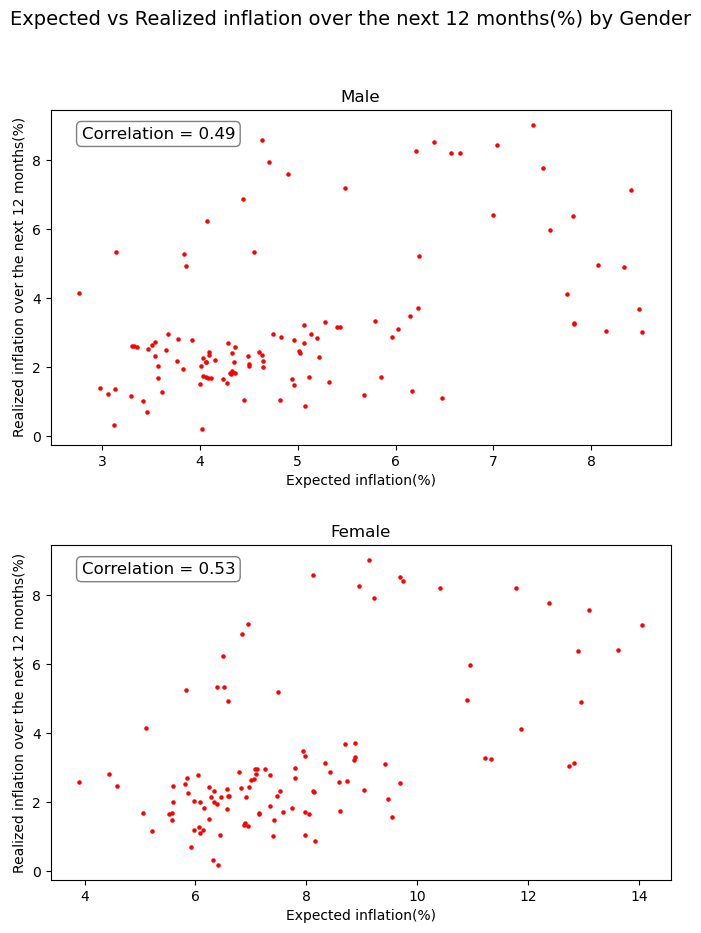

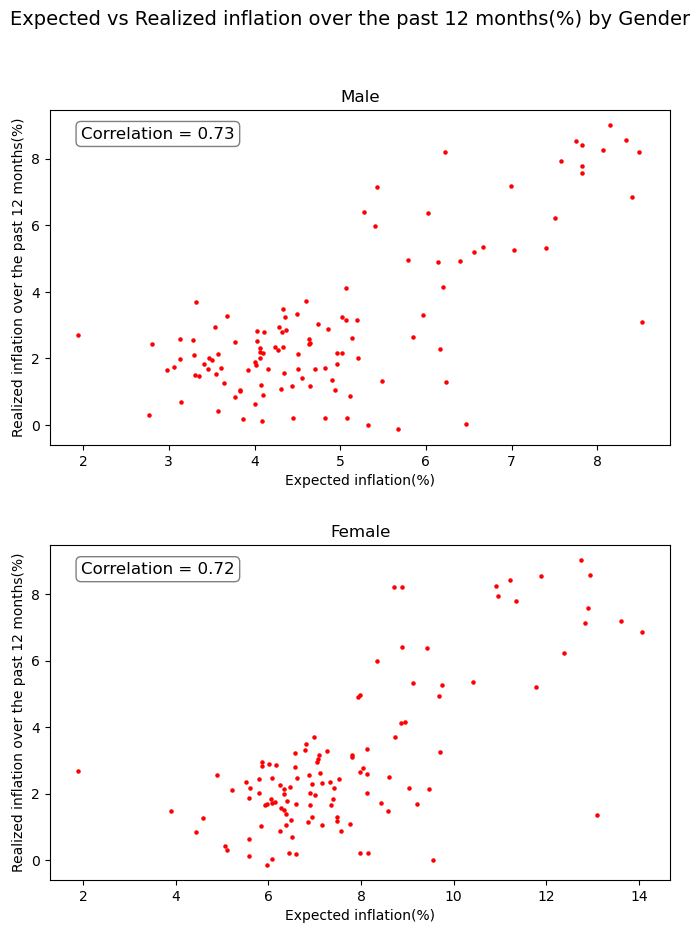

In [22]:
#Reading in the CPI data
cpi_df=pd.read_csv('data/CPI.csv',parse_dates=['DATE'])

#Calculating the 12M forward looking inflation data
cpi_df["Real_Inflation_Future"]=(cpi_df["CPI"].shift(-12) - cpi_df["CPI"]) / cpi_df["CPI"] * 100

#Calculating the 12M backward looking inflation data
cpi_df["Real_Inflation_Past"] = cpi_df["CPI"].pct_change(periods=12) * 100


#changing the name of the date column for merging
monthly_gender=monthly_gender.rename(columns={'date':'DATE'})

#Merging the data
cpi_merged=cpi_df.merge(monthly_gender,on='DATE')
cpi_merged.set_index('DATE',inplace=True)



def plot_gender_inflation(df, y_var, title_y_label=None):
   
    # Separate male and female data
    male_data = df[df['female'] == 0]
    female_data = df[df['female'] == 1]

    # Compute correlations
    male_corr = male_data['inflation'].corr(male_data[y_var])
    female_corr = female_data['inflation'].corr(female_data[y_var])

    # Create the panels
    fig, ax = plt.subplots(2, 1, figsize=(8, 10))

    # Male scatter plot
    ax[0].scatter(male_data['inflation'], male_data[y_var], s=5, c='r')
    ax[0].set_title('Male')
    ax[0].set_xlabel('Expected inflation(%)')
    ax[0].set_ylabel(title_y_label if title_y_label else y_var)

    ax[0].text(
        0.05, 0.95, f"Correlation = {male_corr:.2f}",
        transform=ax[0].transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.5)
    )

    # Female scatter plot
    ax[1].scatter(female_data['inflation'], female_data[y_var], s=5, c='r')
    ax[1].set_title('Female')
    ax[1].set_xlabel('Expected inflation(%)')
    ax[1].set_ylabel(title_y_label if title_y_label else y_var)

    ax[1].text(
        0.05, 0.95, f"Correlation = {female_corr:.2f}",
        transform=ax[1].transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.5)
    )

    plt.subplots_adjust(wspace=0.4, hspace=0.3)
    plt.suptitle(f"Expected vs {title_y_label if title_y_label else y_var} by Gender", fontsize=14)
    plt.show()

plot_gender_inflation(cpi_merged, "Real_Inflation_Future", title_y_label="Realized inflation over the next 12 months(%)")

plot_gender_inflation(cpi_merged, "Real_Inflation_Past", title_y_label="Realized inflation over the past 12 months(%)")

## Part 5 — Expectations vs. Realized Inflation

### 1. Correlation Between Expected and Realized Inflation

The results show a clear **positive relationship** between expected and realized inflation.  
However, the strength of this relationship differs depending on whether individuals are predicting the **past** or the **future**:

- For the **past 12 months**, the correlation is **strong** (around 0.72–0.73).  
  This suggests that people’s expectations about past inflation align closely with what actually happened.
- For the **next 12 months**, the correlation is **weaker** (around 0.49–0.53).  
  This means individuals are less accurate when predicting future inflation than when recalling recent price changes.

---

### 2. Interpretation of Results

These patterns suggest that people often **extrapolate from recent experiences** when forming inflation expectations.  
Rather than basing their beliefs on economic forecasts or long-term trends, they rely on **past inflation** to predict the future — showing an **adaptive** rather than **forward-looking** expectation process.

---

### 3. Gender Differences

The correlations are slightly higher for **females (0.53 vs. 0.49)** when predicting future inflation,  
and almost identical between genders for past inflation (0.72–0.73).  

This indicates that both men and women adjust their expectations in similar ways,  
though women may track short-term changes in inflation **slightly more closely**,  
possibly reflecting a higher sensitivity to changes in everyday prices.

---

**Overall:**  
Individuals form inflation beliefs mainly based on **recent experience** rather than forward-looking analysis.  
While gender differences exist, they are **minor**, suggesting that both groups rely heavily on observed price movements when shaping expectations.